# IBM Data Science Capstone Project - week 5 notebook

This notebook contains the entire code for the capstone project 5 submission.

# Data retrieval and exploration for New York and Manhattan

In this section, the notebook of the week 3 lab is reused.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
!curl -o 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('New York data downloaded!')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  113k  100  113k    0     0      0      0 --:--:-- --:--:-- --:--:--     0 98783      0  0:00:01  0:00:01 --:--:-- 98783
New York data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
NY_neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
NY_neighborhoods = pd.DataFrame(columns = column_names)

for data in NY_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
NY_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
print('The data loaded on New York shows {} boroughs and {} neighborhoods.'.format(
        len(NY_neighborhoods['Borough'].unique()),
        NY_neighborhoods.shape[0]
    )
)

The data loaded on New York shows 5 boroughs and 306 neighborhoods.


Now focus on Manhattan

In [7]:
manhattan_data = NY_neighborhoods[NY_neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [8]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [9]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [10]:
with open("FourSqu_cred.json", "r") as f:
    data = json.load(f)
CLIENT_ID = data['CLIENT_ID']
CLIENT_SECRET = data['CLIENT_SECRET']
VERSION = data['VERSION']

LIMIT = 100

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [14]:
print('There are {} venues identified in Manhattan.'.format(manhattan_venues.shape[0]))

There are 3219 venues identified in Manhattan.


In [15]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,86,86,86,86,86,86
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


In [16]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Res

In [17]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Res

In [18]:
manhattan_grouped.shape

(40, 324)

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
MAN_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
MAN_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    MAN_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

MAN_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,Playground
1,Carnegie Hill,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Yoga Studio,Wine Shop,Vietnamese Restaurant
2,Central Harlem,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,Cosmetics Shop,Cafeteria,Grocery Store,Library
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Park,Cycle Studio,Cupcake Shop
4,Chinatown,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant,Salon / Barbershop,Spa,Noodle House,Optical Shop,Hotpot Restaurant


### Cluster Manhattan Neighborhoods

In [21]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1], dtype=int32)

In [22]:
# add clustering labels
MAN_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(MAN_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,Pizza Place,Deli / Bodega,Department Store,Pharmacy,Diner
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant,Salon / Barbershop,Spa,Noodle House,Optical Shop,Hotpot Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Café,Bakery,Grocery Store,Latin American Restaurant,Deli / Bodega,New American Restaurant,Donut Shop,Mobile Phone Shop,Chinese Restaurant,Sandwich Place
3,Manhattan,Inwood,40.867684,-73.921210,2,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop,Deli / Bodega,Pizza Place,Wine Bar,Caribbean Restaurant,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Liquor Store,Sushi Restaurant,Park,Deli / Bodega


In [23]:
# create map
map_MAN_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_MAN_clusters)
       
map_MAN_clusters

# Data retrieval and exploration Toronto and Downtown Toronto

In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# note: the below libraries have already been imported above

#import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors

# import k-means from clustering stage
#from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

#print('Libraries imported.')

## 2. Scrape wikipedia page

Data source is: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Approach chosen: Pandas web scraping (see also: https://pythonbasics.org/pandas-web-scraping/)

In [25]:
# make sure that beautiful is installed
!pip install lxml html5lib beautifulsoup4  

In [26]:
# load the neighborhood table from the wikipedia page into a pandas dataframe
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data_frames = pd.read_html(url)       # data_frames contains several tables
neighborhood_df = data_frames[0]      # select the first table
neighborhood_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## 3. Create the dataframe

In [27]:
# remove all rows with Borough == "Not Assigned"
neighborhood_df.drop(neighborhood_df[neighborhood_df['Borough'] == "Not assigned"].index, inplace = True)
neighborhood_df.shape

(103, 3)

103 is also the number of neighborhoods (FSA) indicated on the wikipedia page.
So, now we have a working table.

## 4. Load geospatial data

Load longitude and latitude of each postal code and then merge with neighborhood data frame.

In [28]:
#!curl -O http://cocl.us/Geospatial_data        doesn't work with the shortened url provided
#geo_df = pd.read_csv("Geospatial_data.csv")

# try python way:
import io
import requests

url = "http://cocl.us/Geospatial_data"
geo = requests.get(url).text
geo_df = pd.read_csv(io.StringIO(geo))

geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [29]:
To_df = pd.merge(neighborhood_df, geo_df, how = 'inner', left_on = 'Postal Code', right_on = 'Postal Code')

# rename column 'Neighborhood' for consistency with Manhattan
To_df.rename(columns = {'Neighbourhood': 'Neighborhood'}, inplace = True)

print(To_df.shape)
To_df.head()

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## 5. Explore and cluster the neighborhoods 

#### Check number of boroughs and neighborhoods

In [30]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(To_df['Borough'].unique()),
        To_df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Create a map of Toronto with neighborhoods superimposed on top

In [31]:
# retrieve latitude and longitude of Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent = "To_explorer")
location = geolocator.geocode(address)
print(location, location.latitude, location.longitude)

# create the map
map_To = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(To_df['Latitude'], To_df['Longitude'], To_df['Borough'], To_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_To)  
    
map_To

Toronto, Golden Horseshoe, Ontario, Canada 43.6534817 -79.3839347


## Simplify to only those boroughs of ' Downtown Toronto'  

Similar to the focus on Manhattan in the New York data exploration, we now focus on Downtown Toronto.

In [32]:
ToC_df = To_df[To_df['Borough'].str.contains('Downtown Toronto')]
ToC_df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576


In [33]:
ToC_df.shape

(19, 5)

Show map with this selection and zoom in a little

In [34]:
# create the map around the coordinates of Central Bay Street, Downtown Toronto
map_ToC = folium.Map([ToC_df.loc[24, 'Latitude'], ToC_df.loc[24, 'Longitude']], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(ToC_df['Latitude'], ToC_df['Longitude'], ToC_df['Borough'], ToC_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ToC) 

map_ToC

In [35]:
# the below is already executed in the week3 lab

#with open("FourSqu_cred.json", "r") as f:
#    data = json.load(f)
#CLIENT_ID = data['CLIENT_ID']
#CLIENT_SECRET = data['CLIENT_SECRET']
#VERSION = data['VERSION']
#
#LIMIT = 100

#### Get venues within a radius of 500m around the coordinates of each of the neighborhoods

In [36]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [37]:
# function to explore all neighborhoods in a data frame
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
ToC_venues = getNearbyVenues(names = ToC_df['Neighborhood'],
                                   latitudes = ToC_df['Latitude'],
                                   longitudes = ToC_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [39]:
ToC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [40]:
ToC_venues.shape

(1253, 7)

In [41]:
# there is Venue Category 'Neighborhood' that will conflict later with the column 'Neighborhood'
# replace this Venue Category with 'Neighborhood_'
ToC_venues.replace(to_replace = 'Neighborhood', value = 'Neighborhood_', inplace = True)

In [42]:
print('There are {} uniques venue categories.'.format(len(ToC_venues['Venue Category'].unique())))

There are 214 uniques venue categories.


#### Number of venues for each neighborhood

In [43]:
ToC_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


#### Analyze each neighborhood

In [44]:
# one hot encoding
ToC_onehot = pd.get_dummies(ToC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ToC_onehot['Neighborhood'] = ToC_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [ToC_onehot.columns[-1]] + list(ToC_onehot.columns[:-1])
ToC_onehot = ToC_onehot[fixed_columns]

# restore name of Neighborhood column

ToC_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Par

In [45]:
ToC_onehot.shape

(1253, 215)

Simplify onehot table by grouping per neighborhood and by taking the mean of the frequency of occurance of each category

In [46]:
ToC_grouped = ToC_onehot.groupby("Neighborhood").mean().reset_index()
ToC_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.018182,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.018182,0.036364,0.0,0.000000,0.0,0.018182,0.018182,0.0,0.036364,0.0,0.0,0.018182,0.000000,0.000000,0.000000,0.0,0.018182,0.0,0.000000,0.0,0.000000,0.0,0.0,0.018182,0.0,0.0000,0.000000,0.036364,0.000000,0.0,0.0,0.000000,0.036364,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.000000,0.018182,0.0,0.018182,0.0,0.000000,0.0,0.018182,0.000000,0.0,0.018182,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.018182,0.0,0.000000,0.000000,0.0,0.000000,0.036364,0.000000,0.0,0.018182,0.000000,0.0,0.0,0.018182,0.018182,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.018182,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.000000,0.0,0.0,0.018182,0.018182,0.018182,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018182,0.0,0.0,0.000

In [47]:
ToC_grouped.shape

(19, 215)

Identify 10 most common venue categories per neighbourhood

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ToC_grouped['Neighborhood']

for ind in np.arange(ToC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ToC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Restaurant,Farmers Market,Cocktail Bar,Seafood Restaurant,Beer Bar,Cheese Shop,Park,Shopping Mall
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Bar,Historic Site,Plane,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry
2,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Burger Joint,Thai Restaurant,Department Store,Bubble Tea Shop
3,Christie,Grocery Store,Café,Park,Candy Store,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop
4,Church and Wellesley,Coffee Shop,Gay Bar,Sushi Restaurant,Japanese Restaurant,Restaurant,Café,Hotel,Mediterranean Restaurant,Yoga Studio,Men's Store


#### Cluster neighbourhoods by k-means

In [50]:
# set number of clusters
kclusters = 5

ToC_grouped_clustering = ToC_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ToC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 2, 0, 0, 0, 0, 0, 4], dtype=int32)

In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ToC_merged = ToC_df

# merge ToC_grouped with ToC_data to add latitude/longitude for each neighborhood
ToC_merged = ToC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove postal code
ToC_merged.drop(['Postal Code'], axis = 1, inplace = True)

ToC_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Bank,Smoothie Shop,Beer Bar,Sandwich Place,Restaurant,Café,Portuguese Restaurant,Chinese Restaurant
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Bookstore,Diner,Pizza Place,Italian Restaurant
15,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Beer Bar,Clothing Store,Gym,Moroccan Restaurant
20,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Bakery,Restaurant,Farmers Market,Cocktail Bar,Seafood Restaurant,Beer Bar,Cheese Shop,Park,Shopping Mall


#### Visualize cluster labels in a map

In [52]:
# create map
map_clusters = folium.Map(location = [ToC_df.loc[24, 'Latitude'], ToC_df.loc[24, 'Longitude']], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ToC_merged['Latitude'], ToC_merged['Longitude'], ToC_merged['Neighborhood'], ToC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Show neighbourhoods per cluster

Cluster 1

In [53]:
ToC_merged.loc[ToC_merged['Cluster Labels'] == 0, ToC_merged.columns[[1] + list(range(5, ToC_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
4,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Bank,Smoothie Shop,Beer Bar,Sandwich Place,Restaurant,Café,Portuguese Restaurant,Chinese Restaurant
9,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Bookstore,Diner,Pizza Place,Italian Restaurant
15,St. James Town,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Beer Bar,Clothing Store,Gym,Moroccan Restaurant
20,Berczy Park,Coffee Shop,Bakery,Restaurant,Farmers Market,Cocktail Bar,Seafood Restaurant,Beer Bar,Cheese Shop,Park,Shopping Mall
24,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Burger Joint,Thai Restaurant,Department Store,Bubble Tea Shop
30,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Gym,Hotel,Bar,Clothing Store,Thai Restaurant,Salad Place,Concert Hall
36,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Brewery,Pizza Place,Scenic Lookout,Restaurant,Bakery
42,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,American Restaurant,Salad Place,Seafood Restaurant,Bar,Gastropub
48,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Hotel,Café,Gym,Deli / Bodega,Japanese Restaurant,Seafood Restaurant,American Restaurant,Thai Restaurant


Cluster 2

In [54]:
ToC_merged.loc[ToC_merged['Cluster Labels'] == 1, ToC_merged.columns[[1] + list(range(5, ToC_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Rosedale,Park,Playground,Trail,Tennis Court,Deli / Bodega,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar


Cluster 3

In [55]:
ToC_merged.loc[ToC_merged['Cluster Labels'] == 2, ToC_merged.columns[[1] + list(range(5, ToC_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Christie,Grocery Store,Café,Park,Candy Store,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop


Cluster 4

In [56]:
ToC_merged.loc[ToC_merged['Cluster Labels'] == 3, ToC_merged.columns[[1] + list(range(5, ToC_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Bar,Historic Site,Plane,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry


Cluster 5

In [57]:
ToC_merged.loc[ToC_merged['Cluster Labels'] == 4, ToC_merged.columns[[1] + list(range(5, ToC_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,"University of Toronto, Harbord",Café,Bookstore,Sandwich Place,Bar,Japanese Restaurant,Bakery,Yoga Studio,Italian Restaurant,Beer Bar,Beer Store
84,"Kensington Market, Chinatown, Grange Park",Mexican Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Café,Bar,Vietnamese Restaurant,Grocery Store,Dessert Shop,Park,Pizza Place


# Preparing the data for comparative exploration and analysis

## Merge neighboorhood - venues data from Manhattan and Toronto

Clean existing tables

In [58]:
# drop Manhattan-specific cluster labels
MAN_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis = 1, inplace = True)

# insert a column Manhattan
MAN_neighborhoods_venues_sorted.insert(0, 'Borough', 'Manhattan')

MAN_neighborhoods_venues_sorted.head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,Playground
1,Manhattan,Carnegie Hill,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Yoga Studio,Wine Shop,Vietnamese Restaurant
2,Manhattan,Central Harlem,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,Cosmetics Shop,Cafeteria,Grocery Store,Library
3,Manhattan,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Park,Cycle Studio,Cupcake Shop
4,Manhattan,Chinatown,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant,Salon / Barbershop,Spa,Noodle House,Optical Shop,Hotpot Restaurant


In [59]:
MAN_neighborhoods_venues_sorted.shape

(40, 12)

In [60]:
#drop Toronto-specific cluster labels
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis = 1, inplace = True)

# insert a column inner Toronto
neighborhoods_venues_sorted.insert(0, 'Borough', 'Inner Toronto')

neighborhoods_venues_sorted.head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Inner Toronto,Berczy Park,Coffee Shop,Bakery,Restaurant,Farmers Market,Cocktail Bar,Seafood Restaurant,Beer Bar,Cheese Shop,Park,Shopping Mall
1,Inner Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Bar,Historic Site,Plane,Rental Car Location,Sculpture Garden,Boutique,Boat or Ferry
2,Inner Toronto,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Burger Joint,Thai Restaurant,Department Store,Bubble Tea Shop
3,Inner Toronto,Christie,Grocery Store,Café,Park,Candy Store,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop
4,Inner Toronto,Church and Wellesley,Coffee Shop,Gay Bar,Sushi Restaurant,Japanese Restaurant,Restaurant,Café,Hotel,Mediterranean Restaurant,Yoga Studio,Men's Store


Create a common table of neighborhoods in both cities

In [61]:
all_nbh_venues_sorted = pd.concat([MAN_neighborhoods_venues_sorted, neighborhoods_venues_sorted])

In [62]:
all_nbh_venues_sorted.shape

(59, 12)

In [63]:
all_nbh_venues_sorted.head()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Shopping Mall,Plaza,Burger Joint,Gourmet Shop,Playground
1,Manhattan,Carnegie Hill,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Yoga Studio,Wine Shop,Vietnamese Restaurant
2,Manhattan,Central Harlem,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,Cosmetics Shop,Cafeteria,Grocery Store,Library
3,Manhattan,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Park,Cycle Studio,Cupcake Shop
4,Manhattan,Chinatown,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant,Salon / Barbershop,Spa,Noodle House,Optical Shop,Hotpot Restaurant


In [64]:
all_nbh_venues_sorted.tail()

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Inner Toronto,St. James Town,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Beer Bar,Clothing Store,Gym,Moroccan Restaurant
15,Inner Toronto,"St. James Town, Cabbagetown",Coffee Shop,Restaurant,Café,Pizza Place,Chinese Restaurant,Pub,Italian Restaurant,Bakery,Market,Park
16,Inner Toronto,Stn A PO Boxes,Coffee Shop,Italian Restaurant,Pub,Restaurant,Café,Beer Bar,Seafood Restaurant,Japanese Restaurant,Hotel,Park
17,Inner Toronto,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,American Restaurant,Salad Place,Seafood Restaurant,Bar,Gastropub
18,Inner Toronto,"University of Toronto, Harbord",Café,Bookstore,Sandwich Place,Bar,Japanese Restaurant,Bakery,Yoga Studio,Italian Restaurant,Beer Bar,Beer Store


We have now a (Inner Toronto + Manhattan) data frame, which contains for 40 neighborhoods of Manhattan and 39 neighborhoods of Inner Toronto the 10 most common venues.

In [65]:
ToC_data = ToC_df.drop('Postal Code', 1)
ToC_data.head()

,Borough,Neighborhood,Latitude,Longitude
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,Downtown Toronto,St. James Town,43.651494,-79.375418
20,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [66]:
all_data = pd.concat([manhattan_data, ToC_data])
all_data.shape

(59, 4)

In [67]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
manhattan_grouped_clustering.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,S

In [68]:
manhattan_grouped_clustering.shape

(40, 323)

In [69]:
ToC_grouped_clustering = ToC_grouped.drop('Neighborhood', 1)
ToC_grouped_clustering.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.018182,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.018182,0.036364,0.0,0.000000,0.0,0.018182,0.018182,0.0,0.036364,0.0,0.0,0.018182,0.000000,0.000000,0.000000,0.0,0.018182,0.0,0.000000,0.0,0.000000,0.0,0.0,0.018182,0.0,0.0000,0.000000,0.036364,0.000000,0.0,0.0,0.000000,0.036364,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.000000,0.018182,0.0,0.018182,0.0,0.000000,0.0,0.018182,0.000000,0.0,0.018182,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.018182,0.0,0.000000,0.000000,0.0,0.000000,0.036364,0.000000,0.0,0.018182,0.000000,0.0,0.0,0.018182,0.018182,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.018182,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.000000,0.0,0.0,0.018182,0.018182,0.018182,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.0,0.000000,0.000000

In [70]:
ToC_grouped_clustering.shape

(19, 214)

In [71]:
all_grouped_clustering = manhattan_grouped_clustering.append(ToC_grouped_clustering, ignore_index = True, sort = False)

In [72]:
all_grouped_clustering.shape

(59, 360)

In [73]:
# replace NAN with 0
all_grouped_clustering.fillna(0, inplace = True)
all_grouped_clustering.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,S

# Joint cluster analysis of Downtown Toronto and Manhattan

We use k-means on the previously merged dataframes. The objective of this explorative data analysis step is to identify clusters and cluster properties, in which Downtown Toronto neighborhoods show significant differences to neighborhoods in Manhattan.

In [368]:
# set number of clusters
kclusters = 6       # from several cluster numbers, k = 6 provided the most striking distinction between the two cities

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 3, 3, 3, 3, 1, 3, 1], dtype=int32)

In [75]:
# add clustering labels
all_nbh_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# drop borough column
all_nbh_venues_sorted.drop(['Borough'], axis = 1, inplace = True)

all_nbh_merged = all_data

# merge all_grouped with all_data to add latitude/longitude for each neighborhood
all_nbh_merged = all_nbh_merged.join(all_nbh_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

all_nbh_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,Pizza Place,Deli / Bodega,Department Store,Pharmacy,Diner
1,Manhattan,Chinatown,40.715618,-73.994279,3,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant,Salon / Barbershop,Spa,Noodle House,Optical Shop,Hotpot Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,1,Café,Bakery,Grocery Store,Latin American Restaurant,Deli / Bodega,New American Restaurant,Donut Shop,Mobile Phone Shop,Chinese Restaurant,Sandwich Place
3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop,Deli / Bodega,Pizza Place,Wine Bar,Caribbean Restaurant,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Liquor Store,Sushi Restaurant,Park,Deli / Bodega


## Show and analyze clusters

Cluster 1

In [237]:
cluster1 = all_nbh_merged.loc[all_nbh_merged['Cluster Labels'] == 0, all_nbh_merged.columns[[0, 1] + list(range(5, all_nbh_merged.shape[1]))]]
cluster1

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,"Regent Park, Harbourfront",Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",Coffee Shop,Yoga Studio,Bank,Smoothie Shop,Beer Bar,Sandwich Place,Restaurant,Café,Portuguese Restaurant,Chinese Restaurant
9,Downtown Toronto,"Garden District, Ryerson",Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Bookstore,Diner,Pizza Place,Italian Restaurant
15,Downtown Toronto,St. James Town,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Beer Bar,Clothing Store,Gym,Moroccan Restaurant
20,Downtown Toronto,Berczy Park,Coffee Shop,Bakery,Restaurant,Farmers Market,Cocktail Bar,Seafood Restaurant,Beer Bar,Cheese Shop,Park,Shopping Mall
24,Downtown Toronto,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Japanese Restaurant,Burger Joint,Thai Restaurant,Department Store,Bubble Tea Shop
30,Downtown Toronto,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Gym,Hotel,Bar,Clothing Store,Thai Restaurant,Salad Place,Concert Hall
36,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Brewery,Pizza Place,Scenic Lookout,Restaurant,Bakery
42,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,American Restaurant,Salad Place,Seafood Restaurant,Bar,Gastropub
48,Downtown Toronto,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Hotel,Café,Gym,Deli / Bodega,Japanese Restaurant,Seafood Restaurant,American Restaurant,Thai Restaurant


In [77]:
Cluster1.shape

(14, 12)

Cluster 2

In [78]:
all_nbh_merged.loc[all_nbh_merged['Cluster Labels'] == 1, all_nbh_merged.columns[[0, 1] + list(range(5, all_nbh_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,Pizza Place,Deli / Bodega,Department Store,Pharmacy,Diner
2,Manhattan,Washington Heights,Café,Bakery,Grocery Store,Latin American Restaurant,Deli / Bodega,New American Restaurant,Donut Shop,Mobile Phone Shop,Chinese Restaurant,Sandwich Place
3,Manhattan,Inwood,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop,Deli / Bodega,Pizza Place,Wine Bar,Caribbean Restaurant,Park
4,Manhattan,Hamilton Heights,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Cocktail Bar,Indian Restaurant,Liquor Store,Sushi Restaurant,Park,Deli / Bodega
5,Manhattan,Manhattanville,Seafood Restaurant,Coffee Shop,Bar,Deli / Bodega,Italian Restaurant,Park,Mexican Restaurant,Spanish Restaurant,Gastropub,Lounge
7,Manhattan,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Latin American Restaurant,Sandwich Place,French Restaurant,Cocktail Bar,Beer Bar,Grocery Store
11,Manhattan,Roosevelt Island,Playground,Deli / Bodega,School,Greek Restaurant,Supermarket,Bubble Tea Shop,Pizza Place,Food & Drink Shop,Soccer Field,Farmers Market
20,Manhattan,Lower East Side,Chinese Restaurant,Japanese Restaurant,Ramen Restaurant,Pizza Place,Art Gallery,Pharmacy,Bakery,Café,Coffee Shop,Mexican Restaurant
25,Manhattan,Manhattan Valley,Bar,Coffee Shop,Yoga Studio,Pizza Place,Playground,Thai Restaurant,Mexican Restaurant,Cosmetics Shop,Gym / Fitness Center,Latin American Restaurant
26,Manhattan,Morningside Heights,Park,American Restaurant,Coffee Shop,Bookstore,Burger Joint,Café,Deli / Bodega,Pub,Paper / Office Supplies Store,Seafood Restaurant


Cluster 3

In [79]:
all_nbh_merged.loc[all_nbh_merged['Cluster Labels'] == 2, all_nbh_merged.columns[[0, 1] + list(range(5, all_nbh_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Manhattan,Stuyvesant Town,Park,Pet Service,Gym / Fitness Center,Harbor / Marina,Coffee Shop,Baseball Field,Bar,Bistro,Heliport,Farmers Market


Cluster 4

In [100]:
cluster4 = all_nbh_merged.loc[all_nbh_merged['Cluster Labels'] == 3, all_nbh_merged.columns[[0, 1] + list(range(5, all_nbh_merged.shape[1]))]]
cluster4

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,Chinese Restaurant,Cocktail Bar,Dessert Shop,Bakery,American Restaurant,Salon / Barbershop,Spa,Noodle House,Optical Shop,Hotpot Restaurant
6,Manhattan,Central Harlem,African Restaurant,Bar,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,Cosmetics Shop,Cafeteria,Grocery Store,Library
8,Manhattan,Upper East Side,Exhibit,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,Cosmetics Shop,French Restaurant,Juice Bar,Spa
9,Manhattan,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Wine Shop,Diner,Mexican Restaurant
10,Manhattan,Lenox Hill,Italian Restaurant,Sushi Restaurant,Pizza Place,Coffee Shop,Cocktail Bar,Gym,Gym / Fitness Center,Café,Burger Joint,Salon / Barbershop
12,Manhattan,Upper West Side,Italian Restaurant,Café,Bar,Indian Restaurant,Wine Bar,Pizza Place,Bakery,Coffee Shop,Vegetarian / Vegan Restaurant,Thai Restaurant
13,Manhattan,Lincoln Square,Plaza,Café,Concert Hall,Performing Arts Venue,Theater,Italian Restaurant,Gym / Fitness Center,French Restaurant,Indie Movie Theater,Wine Shop
14,Manhattan,Clinton,Theater,American Restaurant,Gym / Fitness Center,Coffee Shop,Cocktail Bar,Sandwich Place,Gym,Hotel,Italian Restaurant,Spa
15,Manhattan,Midtown,Hotel,Coffee Shop,Bakery,Clothing Store,Theater,Steakhouse,Sporting Goods Shop,Sushi Restaurant,Bookstore,Pizza Place
16,Manhattan,Murray Hill,Japanese Restaurant,Coffee Shop,Hotel,Gym / Fitness Center,Sandwich Place,American Restaurant,Bar,Restaurant,Pizza Place,Italian Restaurant


Cluster 5

In [81]:
all_nbh_merged.loc[all_nbh_merged['Cluster Labels'] == 4, all_nbh_merged.columns[[0, 1] + list(range(5, all_nbh_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Downtown Toronto,Rosedale,Park,Playground,Trail,Tennis Court,Deli / Bodega,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dive Bar


Cluster 6

In [83]:
all_nbh_merged.loc[all_nbh_merged['Cluster Labels'] == 5, all_nbh_merged.columns[[0, 1] + list(range(5, all_nbh_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Downtown Toronto,Christie,Grocery Store,Café,Park,Candy Store,Restaurant,Italian Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop


## Show clusters on maps

In [85]:
# create Manhattan map
map_all_clusters_Man = folium.Map(location = [latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_nbh_merged['Latitude'], all_nbh_merged['Longitude'], all_nbh_merged['Neighborhood'], all_nbh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_all_clusters_Man)
       

# create Inner Toronto map
map_all_clusters_ToC = folium.Map(location = [ToC_df.loc[24, 'Latitude'], ToC_df.loc[24, 'Longitude']], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_nbh_merged['Latitude'], all_nbh_merged['Longitude'], all_nbh_merged['Neighborhood'], all_nbh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_all_clusters_ToC)

# show maps  
map_all_clusters_ToC

In [86]:
map_all_clusters_Man

# Initial discussion of results

The two maps reveal that neighborhoods in central areas of Manhattan and Toronto downtown fall into distinct clusters: In Manhattan they fall all into cluster 4 (turkois color). In downtown Toronto they fall all into cluster 1 (red color). This major difference is what we will analyze next in more detail.

These central areas are surrounded in both Manhattan and downtown Toronto by neighborhoods falling the same cluster 2 (purple color). This fact proves that our methodology is correctly clustering by venue category.

The remaining clusters 3, 5 and 6 contain only one neighborhood each. Cluster 3 shows that Stuyvesant Town is distinct from other neighborhoods in Manhattan or downtown Toronto. The Toronto map shows that clusters 5 and 6  are neighborhoods quite far from the the center of downtown and consequently it doesn't come at a surprise to see that these two neighborhoods are not falling clusters common with other downtown Toronto or Manhattan neighborhoods.

In the following we dive deeper into the differences between the clusters 1 (center of downtown Toronto) and 4 (center of Manhattan). This will help us to identify strategies that could help Toronto attract people and talent from Manhattan.

# Further exploration of the venues in the neighborhoods of central Manhattan (cluster 4)

The top10 venue tables for the neighborhoods in cluster 4 feature a lot of restaurant, while the neighborhoods in cluster 1 feature a lot of cafes. Let's get the absolute number of venues and the distribution of restaurants and cafes in both clusters. 

In [97]:
manhattan_onehot.head(1)

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Res

In [96]:
# sum up venue counts per neighborhood

Man_venues = manhattan_onehot.groupby('Neighborhood').sum().reset_index()
Man_venues.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Res

In [98]:
Man_venues.shape

(40, 324)

In [137]:
# filter for neighborhoods in cluster 4
filter_c4 = cluster4['Neighborhood']
c4_filter = filter_c4.reset_index(drop = True)
c4_filter


0             Chinatown
1        Central Harlem
2       Upper East Side
3             Yorkville
4            Lenox Hill
5       Upper West Side
6        Lincoln Square
7               Clinton
8               Midtown
9           Murray Hill
10              Chelsea
11    Greenwich Village
12         East Village
13              Tribeca
14         Little Italy
15                 Soho
16         West Village
17             Gramercy
18        Carnegie Hill
19                 Noho
20         Civic Center
21        Midtown South
22         Sutton Place
23           Turtle Bay
24             Flatiron
25         Hudson Yards
Name: Neighborhood, dtype: object

In [127]:
filter_c4.shape

(26,)

In [102]:
# filter cumulative manhattan venues by cluster 4 neighborhoods

In [138]:
c4_venues = pd.merge(Man_venues, c4_filter, how = 'inner', on = 'Neighborhood')
c4_venues

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Res

In [139]:
# record total number of captured venues by neighborhood for later normalization
c4_venue_sum = c4_venues.sum (axis = 1)
c4_venue_sum.head()

0     86
1     46
2    100
3    100
4    100
dtype: int64

In [140]:
 c4_venue_sum.shape

(26,)

In [107]:
# aggregate all sorts of restaurants in one column
c4_venues.filter(like = 'Restaurant', axis = 1)

,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,2,0,3,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2
1,3,2,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,3,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0,4,0,0,2,0,1,0,0,1,0,7,0,0,2,1,0,0,0,0,0,0,0,0,2,0,0,3,0,0,1,0,0,0,0,1,0,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,2
4,0,3,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0
5,0,5,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,0,1,0,1,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,3,0,2,0,0,3,0,0,0,0,0,5,1,0,0,1,1,0,0,0,0,2,0,0,1,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,3,0,2
7,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5,0,4,0,1,1,0,0,0,0,3,2,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0
8,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,4,0,0,0,0,0,1
9,0,3,0,0,0,0,0,0,0,0,2,3,1,0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,3,0,12,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,2,0,0,0,0,0,5,0,0,0,1,0,1,0,1,1,0,2


In [246]:
c4_restaurant_sum = c4_venues.filter(like = 'Restaurant', axis = 1).sum (axis = 1)
c4_restaurant_sum

0     21
1     15
2     21
3     38
4     23
5     21
6     37
7     32
8     22
9     47
10    13
11    28
12    14
13    24
14    18
15    32
16    38
17    30
18    24
19    27
20    22
21    36
22    23
23    37
24    32
25    30
dtype: int64

In [128]:
c4_restaurant_sum.shape

(26,)

In [131]:
c4_cafe_sum = c4_venues.filter(like = 'Café' or 'Cafeteria' or 'Coffee Shop', axis = 1).sum(axis = 1)
c4_cafe_sum

0     4
1     1
2     2
3     0
4     1
5     1
6     1
7     2
8     2
9     4
10    2
11    3
12    4
13    6
14    2
15    2
16    2
17    2
18    3
19    0
20    3
21    2
22    1
23    4
24    1
25    1
dtype: int64

In [129]:
c4_cafe_sum.shape

(26,)

In [250]:
Cluster4_restaurant_cafe = pd.DataFrame(
    {'Neighborhood': c4_filter, 
     "Restaurants": c4_restaurant_sum,
     "Cafes": c4_cafe_sum,
    "Venues": c4_venue_sum})
Cluster4_restaurant_cafe

,Neighborhood,Restaurants,Cafes,Venues
0,Chinatown,21,4,86
1,Central Harlem,15,1,46
2,Upper East Side,21,2,100
3,Yorkville,38,0,100
4,Lenox Hill,23,1,100
5,Upper West Side,21,1,100
6,Lincoln Square,37,1,100
7,Clinton,32,2,100
8,Midtown,22,2,94
9,Murray Hill,47,4,100


In [251]:
# normalize and clean
Cluster4_restaurant_cafe['Restaurants'] = Cluster4_restaurant_cafe['Restaurants'].div(Cluster4_restaurant_cafe['Venues'], axis = 0)
Cluster4_restaurant_cafe['Cafes'] = Cluster4_restaurant_cafe['Cafes'].div(Cluster4_restaurant_cafe['Venues'], axis = 0)
Cluster4_restaurant_cafe.drop(columns = ['Venues'], inplace = True)
Cluster4_restaurant_cafe

,Neighborhood,Restaurants,Cafes
0,Chinatown,0.244186,0.046512
1,Central Harlem,0.326087,0.021739
2,Upper East Side,0.210000,0.020000
3,Yorkville,0.380000,0.000000
4,Lenox Hill,0.230000,0.010000
5,Upper West Side,0.210000,0.010000
6,Lincoln Square,0.370000,0.010000
7,Clinton,0.320000,0.020000
8,Midtown,0.234043,0.021277
9,Murray Hill,0.470000,0.040000


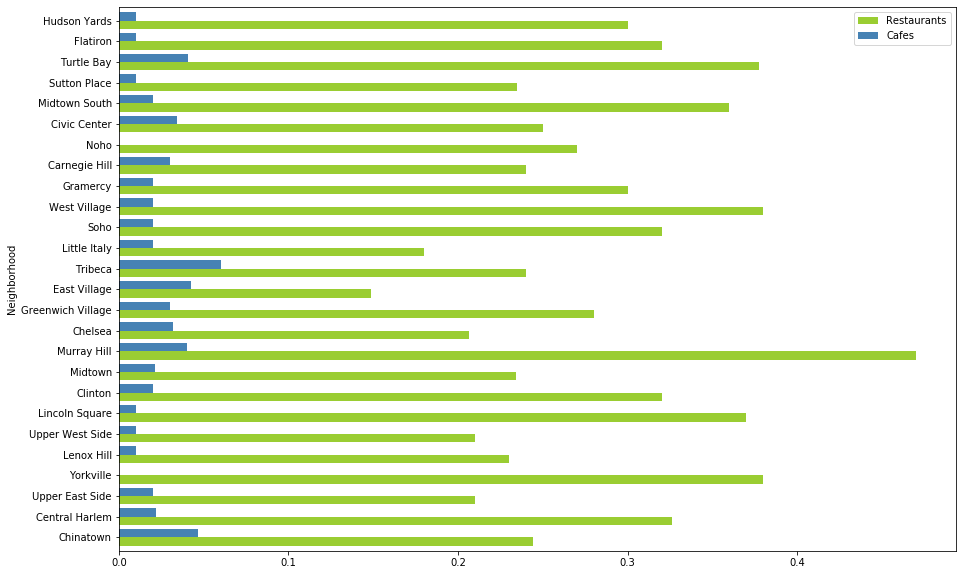

In [265]:
import matplotlib.pyplot as plot

Cluster4_restaurant_cafe.plot.barh(x='Neighborhood', 
                                    color = ['yellowgreen', 'steelblue'], 
                                    width = 0.8, 
                                    figsize = (15, 10))

In [276]:
Cluster4_restaurant_cafe.describe()

,Restaurants,Cafes
count,26.000000,26.000000
mean,0.284686,0.023036
std,0.075318,0.014618
min,0.148936,0.000000
25%,0.234205,0.010051
50%,0.275000,0.020000
75%,0.324565,0.031310
max,0.470000,0.060000


 # Further exploration of the neighborhoods in central Downtown Toronto (cluster 1)

Let's now get the absolute number of venues and the distribution of restaurants and cafes in cluster1, which falls in the central part of Downtown Toronto.

In [229]:
ToC_onehot.head(1)

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [238]:
# sum up venue counts per neighborhood

ToC_venues = ToC_onehot.groupby('Neighborhood').sum().reset_index()
ToC_venues.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,1,1,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,2,5,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,"CN Tower, King and Spadina, Railway Lands, Har...",0,1,1,1,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cen

In [232]:
ToC_venues.shape

(19, 215)

In [239]:
# filter for neighborhoods in cluster 1
filter_c1 = cluster1['Neighborhood']
c1_filter = filter_c1.reset_index(drop = True)
c1_filter

0                             Regent Park, Harbourfront
1           Queen's Park, Ontario Provincial Government
2                              Garden District, Ryerson
3                                        St. James Town
4                                           Berczy Park
5                                    Central Bay Street
6                              Richmond, Adelaide, King
7     Harbourfront East, Union Station, Toronto Islands
8              Toronto Dominion Centre, Design Exchange
9                        Commerce Court, Victoria Hotel
10                       University of Toronto, Harbord
11                                       Stn A PO Boxes
12               First Canadian Place, Underground city
13                                 Church and Wellesley
Name: Neighborhood, dtype: object

In [242]:
filter_c1.shape

(14,)

In [233]:
# filter by cluster 1 neighborhoods

In [240]:
c1_venues = pd.merge(ToC_venues, c1_filter, how = 'inner', on = 'Neighborhood')
c1_venues

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,1,1,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,2,5,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,Central Bay Street,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,2,0,0,4,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,3,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,2,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,0,1,0,0,1,0,1
2,Church and Wellesley,1,0,0,0,0,0,0,

In [244]:
# record total number of captured venues by neighborhood for later normalization
c1_venue_sum = c1_venues.sum (axis = 1)
c1_venue_sum.head()

0     55
1     68
2     75
3    100
4    100
dtype: int64

In [245]:
# aggregate all sorts of restaurants in one column
c1_venues.filter(like = 'Restaurant', axis = 1)

,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,3,2,1,0,0,0,1,1,0,0,1,1,1,1,1,0,1,0,2,0,1,0
2,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,4,0,0,2,1,0,0,0,0,0,0,1,3,0,0,4,0,0,1,0,1
3,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,2,3,0,1,0,0,0,0,0,0,1,0,0,7,3,0,1,0,2,0,2,0
4,0,3,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,4,0,1,1,0,0,0,0,0,1,0,0,4,3,0,2,0,2,0,1,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,2,3,0,0,0,1,2,1,0,0,1,0,2,1,1,0,1,0,1,0,0,1
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,0,1,0,0,0,0,1,0,0,3,1,0,1,0,0,0,1,0
7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,4,1,0,2,0,3,0,1,0


In [247]:
c1_restaurant_sum = c1_venues.filter(like = 'Restaurant', axis = 1).sum (axis = 1)
c1_restaurant_sum

0     13
1     20
2     24
3     30
4     29
5     21
6     13
7      6
8      3
9     23
10    24
11    22
12    26
13     7
dtype: int64

In [248]:
c1_cafe_sum = c1_venues.filter(like = 'Café' or 'Cafeteria' or 'Coffee Shop', axis = 1).sum(axis = 1)
c1_cafe_sum

0     1
1     4
2     2
3     6
4     7
5     4
6     4
7     1
8     2
9     5
10    5
11    3
12    5
13    5
dtype: int64

In [267]:
Cluster1_restaurant_cafe = pd.DataFrame(
    {'Neighborhood': c1_filter, 
     "Restaurants": c1_restaurant_sum,
     "Cafes": c1_cafe_sum,
    "Venues": c1_venue_sum})
Cluster1_restaurant_cafe

,Neighborhood,Restaurants,Cafes,Venues
0,"Regent Park, Harbourfront",13,1,55
1,"Queen's Park, Ontario Provincial Government",20,4,68
2,"Garden District, Ryerson",24,2,75
3,St. James Town,30,6,100
4,Berczy Park,29,7,100
5,Central Bay Street,21,4,100
6,"Richmond, Adelaide, King",13,4,100
7,"Harbourfront East, Union Station, Toronto Islands",6,1,33
8,"Toronto Dominion Centre, Design Exchange",3,2,45
9,"Commerce Court, Victoria Hotel",23,5,100


In [268]:
# normalize and clean
Cluster1_restaurant_cafe['Restaurants'] = Cluster1_restaurant_cafe['Restaurants'].div(Cluster1_restaurant_cafe['Venues'], axis = 0)
Cluster1_restaurant_cafe['Cafes'] = Cluster1_restaurant_cafe['Cafes'].div(Cluster1_restaurant_cafe['Venues'], axis = 0)
Cluster1_restaurant_cafe.drop(columns = ['Venues'], inplace = True)
Cluster1_restaurant_cafe

,Neighborhood,Restaurants,Cafes
0,"Regent Park, Harbourfront",0.236364,0.018182
1,"Queen's Park, Ontario Provincial Government",0.294118,0.058824
2,"Garden District, Ryerson",0.320000,0.026667
3,St. James Town,0.300000,0.060000
4,Berczy Park,0.290000,0.070000
5,Central Bay Street,0.210000,0.040000
6,"Richmond, Adelaide, King",0.130000,0.040000
7,"Harbourfront East, Union Station, Toronto Islands",0.181818,0.030303
8,"Toronto Dominion Centre, Design Exchange",0.066667,0.044444
9,"Commerce Court, Victoria Hotel",0.230000,0.050000


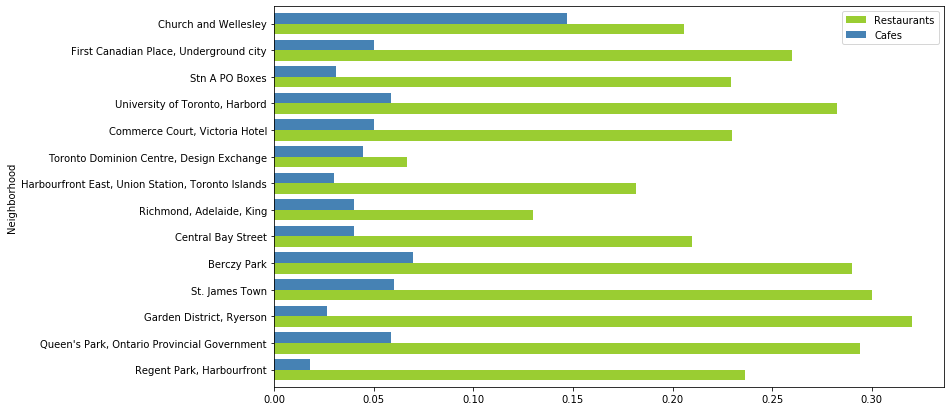

In [271]:
Cluster1_restaurant_cafe.plot.barh(x='Neighborhood', 
                                    color = ['yellowgreen', 'steelblue'], 
                                    width = 0.8, 
                                    figsize = (12, 7))

In [275]:
Cluster1_restaurant_cafe.describe()

,Restaurants,Cafes
count,14.000000,14.000000
mean,0.231169,0.051825
std,0.070359,0.031079
min,0.066667,0.018182
25%,0.206912,0.033438
50%,0.233182,0.047222
75%,0.288088,0.058824
max,0.320000,0.147059


# Comparative statistical analysis of number of restaurants and cafes in clusters 1 and 4

Let's now directly compare the boxplots of the number of restaurants and cafes in the clusters 1 and 4

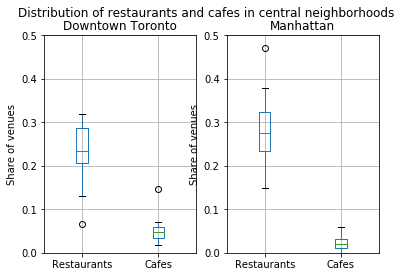

In [360]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Box plot
c1_plot = Cluster1_restaurant_cafe.boxplot(figsize=(20, 6), 
                                           vert = True, 
                                           ax=ax0) # add to subplot 1
ax0.set_title('Downtown Toronto')
ax0.set_ylabel('Share of venues')
ax0.set_ylim(0, 0.5)


# Subplot 1: Box plot
c4_plot = Cluster4_restaurant_cafe.boxplot(figsize=(20, 6), 
                                           vert = True, 
                                           ax=ax1) # add to subplot 1
ax1.set_title('Manhattan')
ax1.set_ylabel('Share of venues')
ax1.set_ylim(0, 0.5)

fig.suptitle('Distribution of restaurants and cafes in central neighborhoods')

plt.show()

## Discussion of the numbers of restaurants and cafes in clusters 1 and 4

This analysis confirms that there are more restaurants in the neighborhoods of central Manhattan (cluster 4) is higher than in those of central Downtown Toronto (cluster 1). Strictly speaking we can now say, that the share of restaurants among all retrieved venues is higher in cluster 4 than in cluster 1. On the other side, we see also confirmation that the share of cafes among all retrieved venues is higher in cluster 1 than in cluster 4.

The distributions of the number of restaurants shows significant differences in the maximum values and in particular the outlier. The above bar chart shows that the outlier is the neighborhood of Murray Hill, which features a restaurant share of not less than 47% of all retrieved restaurants in that neighborhood.

In the big picture however, also considering similar mean restaurant share among all venues is not that much smaller in central Downtown Toronto neighborhoods (cluster 1: 23%) than in central Manhattan neighborhoods (cluster 4: 28%).

At this point we can summarize:
1. Central Downtown Toronto neighborhoods already have more cafes than central Manhattan neighborhoods.
2. The mean share of restaurants among all venues in a neighborhood in central Downtown Toronto neighborhoods is about 5 percentage points below that in central Manhattan neighborhoods.
3. There is a significant lead in the number of restaurants in selected neighborhoods of Manhattan.

So, the next question is: Do we see a bigger difference in the variety of different cuisines?

# Exploration of the variety of cuisines

In [330]:
c4_cuisines = c4_venues.filter(like = 'Restaurant', axis = 1)

In [345]:
c4_variety = np.count_nonzero(c4_cuisines, axis = 1)
c4_variety

array([15,  9, 14, 20, 15, 13, 22, 16, 10, 22,  7, 16,  8, 16, 13,  8, 22,
       19, 14, 16, 12, 17, 12, 23, 13, 15])

In [346]:
Cluster4_cuisines_variety = pd.DataFrame(
    {'Neighborhood': c4_filter, 
     "Cuisines": c4_variety})
Cluster4_cuisines_variety

,Neighborhood,Cuisines
0,Chinatown,15
1,Central Harlem,9
2,Upper East Side,14
3,Yorkville,20
4,Lenox Hill,15
5,Upper West Side,13
6,Lincoln Square,22
7,Clinton,16
8,Midtown,10
9,Murray Hill,22


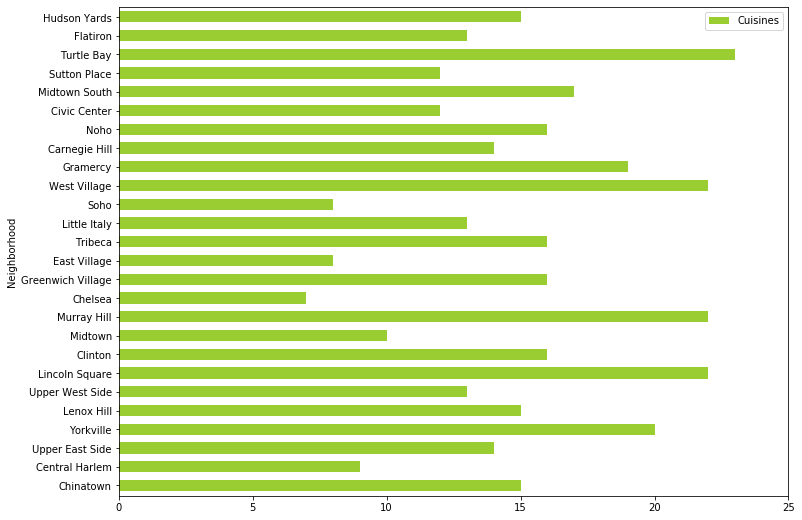

In [366]:
Cluster4_cuisines_variety.plot.barh(x='Neighborhood', 
                                    color = ['yellowgreen'], 
                                    width = 0.6, 
                                    figsize = (12, 9),
                                   xlim = (0, 25))

In [350]:
c1_cuisines = c1_venues.filter(like = 'Restaurant', axis = 1)

In [352]:
c1_variety = np.count_nonzero(c1_cuisines, axis = 1)
c1_variety

array([11, 16, 15, 14, 15, 15, 10,  6,  3, 16, 16, 13, 14,  6])

In [354]:
Cluster1_cuisines_variety = pd.DataFrame(
    {'Neighborhood': c1_filter, 
     "Cuisines": c1_variety})
Cluster1_cuisines_variety

,Neighborhood,Cuisines
0,"Regent Park, Harbourfront",11
1,"Queen's Park, Ontario Provincial Government",16
2,"Garden District, Ryerson",15
3,St. James Town,14
4,Berczy Park,15
5,Central Bay Street,15
6,"Richmond, Adelaide, King",10
7,"Harbourfront East, Union Station, Toronto Islands",6
8,"Toronto Dominion Centre, Design Exchange",3
9,"Commerce Court, Victoria Hotel",16


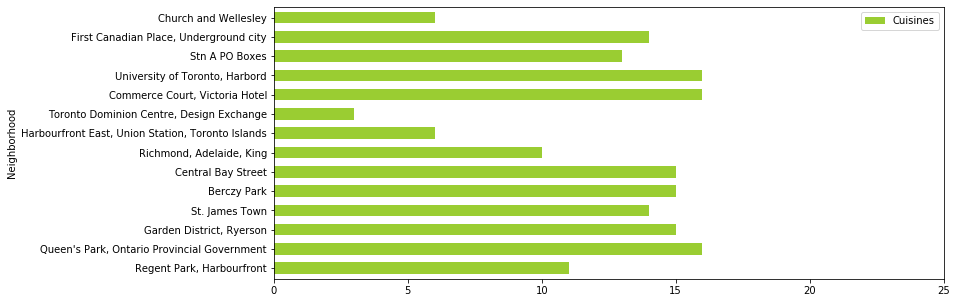

In [367]:
Cluster1_cuisines_variety.plot.barh(x='Neighborhood', 
                                    color = ['yellowgreen'], 
                                    width = 0.6, 
                                    figsize = (12, 5),
                                   xlim = (0, 25))

At this point, we see that differences in variety of cuisines between the two clusters are significantly higher than the differences in absolute numbers of cuisines.

# Analysis of the number of different cuisines in the neighborhoods of clusters 1 and 4

Let us measure the noted differences in variety of cuisines (the number of different cuisines) per neighborhood using statistical analysis. 

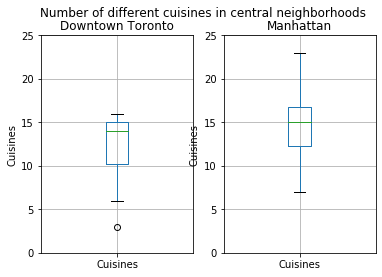

In [361]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Box plot
c1_plot = Cluster1_cuisines_variety.boxplot(figsize=(20, 6), 
                                           vert = True, 
                                           ax=ax0) # add to subplot 1
ax0.set_title('Downtown Toronto')
ax0.set_ylabel('Cuisines')
ax0.set_ylim(0, 25)


# Subplot 1: Box plot
c4_plot = Cluster4_cuisines_variety.boxplot(figsize=(20, 6), 
                                           vert = True, 
                                           ax=ax1) # add to subplot 1
ax1.set_title('Manhattan')
ax1.set_ylabel('Cuisines')
ax1.set_ylim(0, 25)

fig.suptitle('Number of different cuisines in central neighborhoods')

plt.show()

#### Number of different cuisines per neighborhood in central Downtown Toronto

In [369]:
Cluster1_cuisines_variety.describe()

,Cuisines
count,14.000000
mean,12.142857
std,4.312007
min,3.000000
25%,10.250000
50%,14.000000
75%,15.000000
max,16.000000


#### Number of different cuisines per neighborhood in central Manhattan (cluster 4)

In [370]:
Cluster4_cuisines_variety.describe()

,Cuisines
count,26.000000
mean,14.884615
std,4.537197
min,7.000000
25%,12.250000
50%,15.000000
75%,16.750000
max,23.000000


# Discussion (more in the report)

The above data exploration and analysis shows that overall the neighborhoods of central Downtown Toronto are not far behind the neighborhoods of central Manhattan in terms of number of restaurants and variety of cuisines offered by the restaurants.

The existing differences are most clearly visible in the neighborhoods with most restaurants and the biggest choice of cuisines.

The neighborhoods of central Downtown Toronto have more cafes than the neighborhoods of central Manhattan.

# Conclusion (more in the report)

Our analysis suggests that for typical neighborhood in central Downtown Toronto the number of restaurants would need to be increase only modestly to reach typical central Manhattan levels.

Central Downtown Toronto neighborhoods could even afford to turn some cafes into restaurants, and would still have more cafes (as percentage of all venues) than the neighborhoods of central Manhattan.

There is room for improvement in developing number and variety of cuisines in selected neighborhoods.

The top neighborhood of central Downtown Toronto features 32% restaurants among all venues, which is 68% behind the top neighborhood of central Manhattan (47% restaurant share among all venues).

The top neighborhoods of central Downtown Toronto feature restaurants of 16 different cuisines, which is 70% behind the top neighborhoods of central Manhattan (restaurants of 23 difference cuisines).

Our recommendation is to encourage restaurants of missing cuisines in central Downtown Toronto's top eating neighborhoods and develop these neighborhoods to competitiveness with Manhattan's top eating neighborhoods. 